# Modflow Debug GUI

Load formatting extension

In [1]:
%load_ext lab_black

Set matplotlib backend

In [2]:
%matplotlib inline

In [3]:
import os
import sys

from pathlib import Path
import subprocess

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

flopy is installed in C:\Users\hofer_jn\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy
3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.16.5
matplotlib version: 3.1.1
flopy version: 3.2.12


In [4]:
sim_name = "mfsim.nam"
modflow_path = Path("c:/checkouts/modflow6/bin/mf6d.exe")
example_path = Path("c:/checkouts/modflow-debug-gui/data/test120_mv_dis-lgr_3models")

sim = flopy.mf6.MFSimulation.load(
    sim_name=sim_name,
    version="mf6",
    exe_name=str(modflow_path),
    sim_ws=str(example_path),
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package rch...
    loading package riv...
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package riv...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 15 based on size of stress_period_data
    loading package oc...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package rch...
    loading package riv...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 15 based on size of stress_period_data
    loading package oc...
  loading exchange package gwf-gwf_exg_0...
  loading exchange package gwf-gwf_exg_1...
  loading exchange package gwf-gwf_exg_2.

Manual way to run modflow executable
```python
os.chdir(example_path)
completed_process = subprocess.run([str(modflow_path)], stdout=subprocess.PIPE)
if completed_process.returncode:
    print(completed_process.stdout.decode("utf-8"))
```

Run modflow with flopy

In [5]:
sim.run_simulation()

FloPy is using the following  executable to run the model: c:\checkouts\modflow6\bin\mf6d.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.5 03/31/2019
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Nov 06 2019 14:55:12 with IFORT compiler (ver. 19.0.4)

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use of the softwar

(True, [])

Old way to extract head-data with Flopy
```
hds_mv = bf.HeadFile("mv.hds")
hds_child1 = bf.HeadFile("child1.hds")
hds_child2 = bf.HeadFile("child2.hds")

head_mv = hds_mv.get_data(totim=1.0)
head_child1 = hds_child1.get_data(totim=1.0)
head_child2 = hds_child2.get_data(totim=1.0)
```

New way to extract head-data with Flopy

In [11]:
# [-1] in order to get date from the end of the model run
head_mv = sim.simulation_data.mfdata["mv", "HDS", "HEAD"][-1]
head_child1 = sim.simulation_data.mfdata["child1", "HDS", "HEAD"][-1]
head_child2 = sim.simulation_data.mfdata["child2", "HDS", "HEAD"][-1]

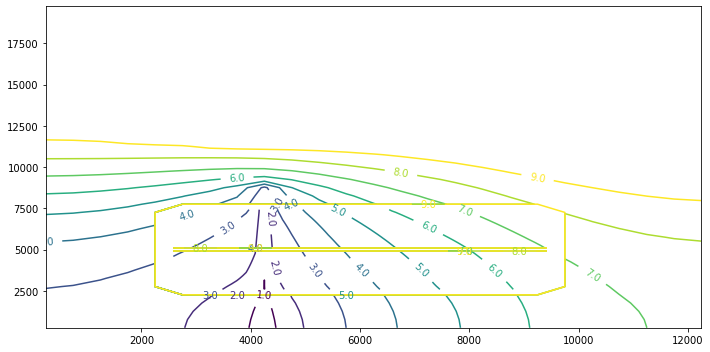

In [23]:
plt.figure(figsize=(10, 5))
levels = np.arange(1, 10, 1)


xorigin = 0
yorigin = 0
nlay = 5
nrow = 40
ncol = 25
delr = 500
delc = 500
Lx = delr * ncol
Ly = delc * nrow
extent = (delr / 2.0, Lx - delr / 2.0, Ly - delc / 2.0, delc / 2.0)
c = plt.contour(head_mv[0, :, :], levels=levels, extent=extent)
plt.clabel(c, fmt="%1.1f")

xorigin = 2500
yorigin = 2500
nlay = 5
nrow = 30
ncol = 42
delr = 166.66666667
delc = 166.66666667
Lx = delr * ncol
Ly = delc * nrow
extent = (
    delr / 2.0 + xorigin,
    Lx - delr / 2.0 + xorigin,
    Ly - delc / 2.0 + yorigin,
    delc / 2.0 + yorigin,
)
c = plt.contour(head_child1[0, :, :], levels=levels, extent=extent)
plt.clabel(c, fmt="%1.1f")

xorigin = 2500
yorigin = 2500
nlay = 5
nrow = 30
ncol = 42
delr = 166.66666667
delc = 166.66666667
Lx = delr * ncol
Ly = delc * nrow
extent = (
    delr / 2.0 + xorigin,
    Lx - delr / 2.0 + xorigin,
    Ly - delc / 2.0 + yorigin,
    delc / 2.0 + yorigin,
)
c = plt.contour(head_child2[0, :, :], levels=levels, extent=extent)
plt.clabel(c, fmt="%1.1f")

plt.tight_layout()
plt.show()

In [8]:
# plt.figure(figsize=(20, 5))

# plt.subplot(1, 3, 1, aspect="equal")
hds = bf.HeadFile("mv.hds")
head = hds.get_data(totim=1.0)
levels = np.arange(1, 10, 1)
plt.imshow(head[0, :, :])

for i in range(len(head[0, 0, :])):
    for j in range(len(head[0, :, 0])):
        text = plt.text(
            i,
            j,
            f"{head[0, j, i]:02.0}",
            ha="center",
            va="center",
            color="w",
            fontsize=5,
        )


# plt.subplot(1, 3, 2)
# hds = bf.HeadFile("child1.hds")
# head = hds.get_data(totim=1.0)
# levels = np.arange(1, 10, 1)
# plt.imshow(head[0, :, :])

# plt.subplot(1, 3, 3)
# hds = bf.HeadFile("child2.hds")
# head = hds.get_data(totim=1.0)
# levels = np.arange(1, 10, 1)
# plt.imshow(head[0, :, :])
# plt.colorbar()

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'mv.hds'

In [ ]:
hds = bf.HeadFile("mv.hds")
head = hds.get_data(totim=1.0)
print(len(head[:, 0, 0]))
print(len(head[0, :, 0]))
print(len(head[0, 0, :]))